# Classement automatique de sms par réseau de neurones

L’objectif de ce TP est de développer un modèle de prédiction de spam sms à partir d’un apprentissage automatique par réseau de neurones et d'une représentation en sac de mots (bag of words).

## Ensemble de données 
Le TP utilisera un ensemble de données issues du site de dépôt de *dataset* [Kaggle](https://www.kaggle.com/datasets).

Plus précisément, vous utiliserez le *dataset* ["SMS SPAM Detection Dataset"](https://www.kaggle.com/datasets/sanutribedi/sms-spam-detection-dataset/download?datasetVersionNumber=1).

Ce *dataset* contient des exemples de sms classées en tant que désirés (0)  et spams (1).


---
Si vous utilisez Colab, vous devrez charger vos fichiers de données dans votre 'Drive' Google.

Pour pouvoir les utiliser, il vous faut monter le répertoire 'drive' pour qu'il soit accessible par Colab.
Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [1]:
#bloc à exécuter si vous utilisez colab
#from google.colab import drive, files

#drive.mount('/content/drive')

---
## Préparation des données


### Creations des fichiers de données

Les données utilisés des exemples d'entraînements sont les colonnes 'text' et 'target'.
Le but est de créer et d'entraîner un réseau à faire correspondre un texte anglais à une classe 'normal (0)' ou 'spam (1)'.

Il s'agit de créer, à partir du fichier , deux ensembles : l'un contenant les texte liés aux sms 'désirés' et l'autre lié aux sms 'spam'.

Il existe plusieurs manière de faire : en passant par la librairie Panda, très performante; ou manuellement.

Si vous ne connaissez pas la suite Panda, procédez manuellement : à partir du fichier contenant les tables, triez les lignes par ordre de 'target'; puis créez 2 fichiers textes à partir de la colonne 'text'. 
L'un contenant les sms classées désirés (`goodsms.txt` par exemple) et l'autre les sms classés smap (`spamsms.txt` par exemple).



In [2]:
""" Importation de Pandas et creation des ensembles pour les SMS désirés (0) et spams (1) """
import pandas as pd

# Chargement du fichier CSV en utilisant la fonction read_csv de pandas
data = pd.read_csv('cleaned_sms_spam.csv')

# Création des deux ensembles distincts pour les SMS "désirés" et "spam" en filtrant les données en fonction de la colonne "target"
desired_sms = data[data['target'] == 0]['text']
spam_sms = data[data['target'] == 1]['text']


In [3]:
print(spam_sms.head())

2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: text, dtype: object


### Réduction des exemples
Le nombre de mots utilisés le vocabulaire, étant assez vaste; on le réduit dans un premier temps

### Création du vocabulaire utile

En chargeant l'ensemble des lignes contenues dans les fichers texte, on crée un vocabulaire des mots utiles en :   
  - identifiant les termes (**tokens**) entre espaces,
  - supprimant toute ponctuation,
  - supprimant tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimant tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimant tous les mots dont la longueur est <= 2 caractères (par exemple)

### Chargement et nettoyage des données

Il convient pour chaque fichier texte de créer le  
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison) français & anglais
  - supprimer tous les mots dont la longueur est <= 2 caractères (sauf IA, AI)



### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichier, ainsi qu'à la bibliothèque nltk et aux bibliothèques spécialisées dans le traitement de texte.. : 

In [4]:
#pip install daal==2021.2.3

In [5]:
#pip install numpy==1.22

In [6]:
""" Installation de tensorflow """
#!pip install tensorflow

' Installation de tensorflow '

In [7]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing
from numpy import array, zeros


In [8]:
#rep = '/Users/...../' ## ICI VOTRE REPERTOIRE DE TRAVAIL LOCAL 
#rep = '/content/drive/My Drive/Colab Notebooks/'  ICI SUR LE DRIVE
rep = '/Users/befat/OneDrive/Bureau/ICy_2/P4/IA modeles et raisonnement/TP/TP2'

# le code suivant charge l'ensemble des mots non importants 
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\befat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Fonctions de lectures et d'"épurage" de fichier texte

In [9]:
def load_doc(filename:str)->list:
    """retourne les lignes de texte du fichier filename"""
    # open the file as read only
    with open(filename) as file:
        text = file.read().splitlines() 
    return text

 
def clean_doc(doc)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words anglais et francais
    retire d autres mots cles comme 'vers', 'lors' , .."""
    tokens = doc.lower()
    tokens = tokens.split()
    # retrait des signes de ponctuation
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # retrait des termes qui ne contiennent pas que des lettres
    tokens = [word for word in tokens if word.isalpha()]
    # retrait des mots de liaisons et juges non signifiants (appeles stopwords)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # retrait des mots de moins de 3 caractères sauf 'IA' et 'AI'
    tokens = [word for word in tokens if len(word) > 2 or word == 'AI' or word == 'IA']

    return tokens


### Tests de la récupération de mots clés d'un fichier

In [10]:
def test_recup():
    # mots clés du fichier des bons sms
    text_desired = ' '.join(desired_sms)
    tokens_desired = clean_doc(text_desired)
    print('Les 10 premiers mots cles des SMS "désirés":\n')
    print(tokens_desired[:10])
    # mots clés de l'ensemble des sms spams
    text_spam = ' '.join(spam_sms)
    tokens_spam = clean_doc(text_spam)
    print('\n\nLes 10 premiers mots cles des SMS "spam":\n')
    print(tokens_spam[:10])    

In [11]:
test_recup()

Les 10 premiers mots cles des SMS "désirés":

['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'got']


Les 10 premiers mots cles des SMS "spam":

['free', 'entry', 'wkly', 'comp', 'win', 'cup', 'final', 'tkts', 'may', 'text']


### Construire le vocabulaire global

In [12]:
def add_doc_to_vocab(text, vocab):
    """cumule dans la liste vocab les mots de l'ensemble text 
    (1 seule occurence par mot dans vocab)"""
    # clean doc
    tokens = clean_doc(text)
    # update counts
    vocab.update(tokens)

def create_global_vocabulary():
    """creer un vocabulaire (liste de mots clés associés à leurs occurences)
    par la suite, un mot d'un texte ne faisant pas partie du vocabulaire ne sera
    pas compte"""
    vocab = Counter()
    # Ajouter les mots clés de l'ensemble desired_sms
    for text in desired_sms:
        add_doc_to_vocab(text, vocab)
    # Ajouter les mots clés de l'ensemble spam_sms
    for text in spam_sms:
        add_doc_to_vocab(text, vocab)

    # Afficher le nombre de mots clés trouvés
    print("Nombre de mots clés trouvés dans les ensembles : ", len(vocab))
    print("Les 10 premiers mots clés du vocabulaire (et leur nombre d'apparition dans les exemples) :")
    for i, (mot, count) in enumerate(vocab.items()):
        print(mot, ':', count, end=", ")
        if i >= 9:
            break
    # Afficher les 10 mots clés les plus utilisés
    print("\nLes 10 mots clés les plus utilisés : ", vocab.most_common(10))

    # Ne garder que les mots clés apparaissant au moins 4 fois
    min_occurrence = 4
    tokens = [token for (token, count) in vocab.items() if count >= min_occurrence]
    print("En ôtant les mots utilisés moins de", min_occurrence, "fois, le nombre de mots clés =", len(tokens))
    return tokens

In [13]:
## Sauvegarde du vocabulaire
def save_list(lines, filename):
    """sauve les mots de la liste lines dans le fichier filename"""
    # open file
    file = open(filename, 'w')
    data = '\n'.join(lines)
    # write text
    file.writelines(data)
    # close file
    file.close()

In [14]:
## A la 1ere utilisation, et a chaque modification des fichiers de données
tokens = create_global_vocabulary()
save_list(tokens, 'vocabSMS.txt')

Nombre de mots clés trouvés dans les ensembles :  7894
Les 10 premiers mots clés du vocabulaire (et leur nombre d'apparition dans les exemples) :
jurong : 1, point : 13, crazy : 15, available : 14, bugis : 7, great : 103, world : 24, buffet : 2, cine : 7, got : 231, 
Les 10 mots clés les plus utilisés :  [('call', 487), ('get', 364), ('dont', 258), ('ltgt', 254), ('free', 243), ('know', 239), ('got', 231), ('like', 231), ('good', 217), ('come', 210)]
En ôtant les mots utilisés moins de 4 fois, le nombre de mots clés = 1665


### Réduction des entrées
Chaque entrée texte peut être maintenant simplifiée.
Ce n'est pas nécessaire car l'outil de NLP le fera, par la suite.

Pour épurer : pour chaque entrée, on extrait les tokens qui ne sont pas présents dans le vocabulaire utile.

In [15]:
def filter_line(line, vocab)->list:
    """retourne la liste des mots cles de la ligne appartenant au vocabulaire vocab"""
    # clean line
    tokens = clean_doc(line)    
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

Pour chaque fichier d'exemples, on en retire deux ensembles de lignes (positive_lines pour les bons sms, negative_lines pour les spams).

In [16]:
def process_train_file(filenametrain, vocab)->list:
    """retourne la listes des lignes epurees a partir du fichier 'filenametrain' """
    lines_train = list()
    i=1
    lines = list()
    # load and clean the file
    with open(filenametrain) as file:
        lines = file.read().splitlines()
    filtered_lines = [filter_line(line, vocab) for line in lines]
    return filtered_lines

In [17]:
def process_train_data(traindata, vocab)->list:
    """retourne la listes des lignes epurees a partir d'ensemble 'traindata' """
    filtered_lines = [filter_line(line, vocab) for line in traindata]
    return filtered_lines

In [18]:
# Charger le vocabulaire si nécessaire
vocab_filename = 'vocabSMS.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab)

# Créer les lignes épurées pour les exemples d'entraînement positifs
positive_lines = process_train_data(desired_sms, vocab)
# Créer les lignes épurées pour les exemples d'entraînement négatifs
negative_lines = process_train_data(spam_sms, vocab)

# Résumé des exemples d'entraînement
print("Nombre d'exemples d'entraînement positifs:", len(positive_lines))
print("Nombre d'exemples d'entraînement négatifs:", len(negative_lines))

Nombre d'exemples d'entraînement positifs: 4516
Nombre d'exemples d'entraînement négatifs: 653


---
## Représentation en sac de mots



### Convertir les exemples en vecteurs
Chaque exemple doit être transformé dans un vecteur de même format.
On recrée un vocabulaire des mots présents dans les exemples; puis pour chaque exemple, on crée un vecteur de 0, 1 (1 si le ie mot du vocabulaire existe dans l'exemple).

Ainsi tous les exemples de ligne sont transformés en vecteurs de même dimension.

On utilise pour cela un "Tokenizer"


In [19]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
# build the training doc based on training data
training_doc = list()
training_doc.extend(positive_lines)
training_doc.extend(negative_lines)
# ask to the tokenizer to build the bag of words : a set of (word, use)*
tokenizer.fit_on_texts(training_doc)

"Il ne reste plus qu'à" demander au 'Tokenizer' de réaliser la transformation des exemples d'entraînement en vecteurs d'entraînement.

In [20]:
xTrain = tokenizer.texts_to_matrix(training_doc, mode='freq')
##TODO: regarder les autres modes que freq; par exemple 'bin', qu'apportent-ils ?
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  5169  exemples de  1666  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


In [21]:
##Le mode binary indique la presence (1) ou l'absence (0) d'un mot dans l'exemple
xTrain = tokenizer.texts_to_matrix(training_doc, mode='binary')
print('xTrain contient', xTrain.shape[0], 'exemples de', xTrain.shape[1], 'valeurs')
print('Une valeur = présence ou absence d\'un mot dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entraînement = \n', xTrain[0])

xTrain contient 5169 exemples de 1666 valeurs
Une valeur = présence ou absence d'un mot dans le vocabulaire global.
Ainsi, premier exemple d'entraînement = 
 [0. 0. 0. ... 0. 0. 0.]


In [22]:
##Le mode count perme tde connaitre le nombre d'occurrences de chaque mot dans l'exemple
xTrain = tokenizer.texts_to_matrix(training_doc, mode='count')
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = nombre d\'occurrences des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  5169  exemples de  1666  valeurs
une valeur = nombre d'occurrences des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


In [23]:
##Le mode tdidf attribue un poids plus élevé aux mots qui apparissent fréquemment dans l'exemple mais rarement dans le vocab
xTrain = tokenizer.texts_to_matrix(training_doc, mode='tfidf')
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = poids TF-IDF du mot dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  5169  exemples de  1666  valeurs
une valeur = poids TF-IDF du mot dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


#### Création des sorties
Les premiers vecteurs représente des exemples positifs. On crée une sortie constituée d'autant de valeurs [1] suivie de valeurs [0]. 

In [24]:
#ytrain = suite de (0 (classement pour eval positive),  1 (classements pour éval négative))
yTrain = zeros(len(positive_lines)+len(negative_lines))
yTrain[:len(positive_lines)] = 1

---
## Modèle de réseau pour l'analyse des sms
Le réseau contient en couche d'entrée autant de neurones que de tokens retenus. 
Chaque exemple est codé sous forme d'une suite de 0 ou 1, d'une dimension égale au vocabulaire retenu.

xTrain est donc une matrice de n exemples x m colonnes. m étant la dimension des vecteurs d'entrée, c-a-d le nombre de mots finalement pris en comptes, et donc le nombre de neurones de la 1er couche du réseau

In [25]:
# nb de neurones en entrée (= nb de tokens retenus)
## shape[0] est la 1ere dimension d'un tableau (ici le nb d'exemples)
## shape[1] est la 1ere dimension d'un tableau (ici le nb de tokens)
n_words = xTrain.shape[1] 

### Définition de 5 architectures différentes

In [26]:
# TODO: définir la structure du réseau
# Architecture 1
model1 = Sequential()
model1.add(Dense(32, activation='relu', input_shape=(n_words,)))  # Couche d'entrée avec 32 neurones
model1.add(Dense(1, activation='sigmoid'))  # Couche de sortie avec 1 neurone pour la classification binaire

In [27]:
# Architecture 2
model2 = Sequential()
model2.add(Dense(64, input_shape=(n_words,), activation='relu'))  # Première couche d'entrée avec 64 neurones
model2.add(Dense(32, activation='relu'))  # Deuxième couche cachée avec 32 neurones
model2.add(Dense(1, activation='sigmoid'))  # Couche de sortie avec 1 neurone pour la classification binaire

In [28]:
# Architecture 3
model3 = Sequential()
model3.add(Dense(128, input_shape=(n_words,), activation='elu'))  # Couche d'entrée avec 128 neurones
model3.add(Dense(64, activation='relu'))  # Première couche cachée avec 64 neurones
model3.add(Dense(32, activation='tanh'))  # Deuxième couche cachée avec 32 neurones
model3.add(Dense(1, activation='sigmoid'))  # Couche de sortie avec 1 neurone pour la classification binaire

In [29]:
# Architecture 4
model4 = Sequential()
model4.add(Dense(128, input_shape=(n_words,), activation='relu'))  # Couche d'entrée avec 128 neurones
model4.add(Dense(64, activation='elu'))  # Première couche cachée avec 64 neurones
model4.add(Dense(32, activation='relu'))  # Deuxième couche cachée avec 32 neurones
model4.add(Dense(16, activation='elu'))  # Troisième couche cachée avec 32 neurones
model4.add(Dense(1, activation='sigmoid'))  # Couche de sortie avec 1 neurone pour la classification binaire

In [30]:
# Architecture 5
model5 = Sequential()
model5.add(Dense(128, input_shape=(n_words,), activation='elu'))  # Couche d'entrée avec 128 neurones
model5.add(Dense(64, activation='elu'))  # Première couche cachée avec 64 neurones
model5.add(Dense(32, activation='tanh'))  # Deuxième couche cachée avec 32 neurones
model5.add(Dense(32, activation='relu'))  # Troisième couche cachée avec 32 neurones
model5.add(Dense(16, activation='elu'))  # Quatrième couche cachée avec 16 neurones
model5.add(Dense(1, activation='sigmoid'))  # Couche de sortie avec 1 neurone pour la classification binaire

### Tests des architectures - Dessiner l'évolution de l'erreur et de la pertinence

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

In [31]:
import matplotlib.pyplot as plt

def test(model, epochs, batch_size, steps_per_epoch, validation_split):
    """Fonction de test générique pour effectuer plusieurs tests selon l'architecture et les paramètres de configuration."""

    # Compilation du réseau
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

    # Entraînement du modèle
    history = model.fit(xTrain, yTrain, validation_data=(xTrain, yTrain), epochs=epochs,
                        steps_per_epoch=steps_per_epoch, batch_size=batch_size, validation_split=validation_split, verbose=2)

    # Récupération des métriques d'apprentissage (loss) et de validation (val_loss)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    # Affichage des graphiques de l'évolution de l'erreur et de la précision
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Graphique de l'évolution de l'erreur
    axes[0].plot(range(1, len(loss) + 1), loss, 'b-*', label='Erreur sur exemples d\'apprentissage')
    axes[0].plot(range(1, len(val_loss) + 1), val_loss, 'r-*', label='Erreur sur exemples de validation')
    axes[0].set_title('Évolution de l\'erreur')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Erreur')
    axes[0].legend()

    # Graphique de l'évolution de la précision
    axes[1].plot(range(1, len(acc) + 1), acc, 'b-*', label='Précision sur exemples d\'apprentissage')
    axes[1].plot(range(1, len(val_acc) + 1), val_acc, 'r-*', label='Précision sur exemples de validation')
    axes[1].set_title('Évolution de la précision')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Précision')
    axes[1].legend()

    # Affichage des graphiques
    plt.tight_layout()
    plt.show()

Tests de la première architecture

Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02

Epoch 1/15
10/10 - 2s - loss: 0.5855 - accuracy: 0.7537 - val_loss: 0.4569 - val_accuracy: 0.9191 - 2s/epoch - 176ms/step
Epoch 2/15
10/10 - 0s - loss: 0.4039 - accuracy: 0.9361 - val_loss: 0.3222 - val_accuracy: 0.9638 - 304ms/epoch - 30ms/step
Epoch 3/15
10/10 - 0s - loss: 0.2847 - accuracy: 0.9667 - val_loss: 0.2455 - val_accuracy: 0.9710 - 237ms/epoch - 24ms/step
Epoch 4/15
10/10 - 0s - loss: 0.2282 - accuracy: 0.9744 - val_loss: 0.1969 - val_accuracy: 0.9776 - 311ms/epoch - 31ms/step
Epoch 5/15
10/10 - 0s - loss: 0.1832 - accuracy: 0.9797 - val_loss: 0.1641 - val_accuracy: 0.9797 - 230ms/epoch - 23ms/step
Epoch 6/15
10/10 - 0s - loss: 0.1566 - accuracy: 0.9783 - val_loss: 0.1400 - val_accuracy: 0.9834 - 205ms/epoch - 20ms/step
Epoch 7/15
10/10 - 0s - loss: 0.1351 - accuracy: 0.9827 - val_loss: 0.1220 - val_accuracy: 0.9845 - 202ms/epoch - 20ms/step
Epoch 8/15
10

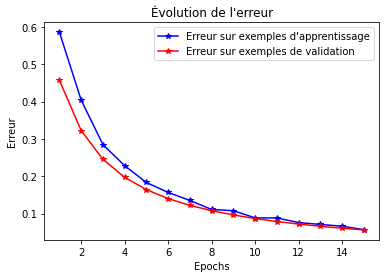

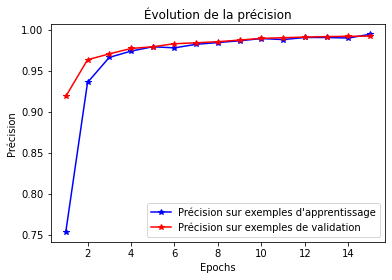

Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 10, validation_split: 0.01

Epoch 1/10
10/10 - 2s - loss: 0.0550 - accuracy: 0.9920 - val_loss: 0.0501 - val_accuracy: 0.9915 - 2s/epoch - 157ms/step
Epoch 2/10
10/10 - 0s - loss: 0.0552 - accuracy: 0.9910 - val_loss: 0.0442 - val_accuracy: 0.9917 - 257ms/epoch - 26ms/step
Epoch 3/10
10/10 - 0s - loss: 0.0453 - accuracy: 0.9924 - val_loss: 0.0384 - val_accuracy: 0.9928 - 210ms/epoch - 21ms/step
Epoch 4/10
10/10 - 0s - loss: 0.0360 - accuracy: 0.9920 - val_loss: 0.0341 - val_accuracy: 0.9930 - 232ms/epoch - 23ms/step
Epoch 5/10
10/10 - 0s - loss: 0.0331 - accuracy: 0.9920 - val_loss: 0.0305 - val_accuracy: 0.9936 - 200ms/epoch - 20ms/step
Epoch 6/10
10/10 - 0s - loss: 0.0293 - accuracy: 0.9954 - val_loss: 0.0278 - val_accuracy: 0.9940 - 230ms/epoch - 23ms/step
Epoch 7/10
10/10 - 0s - loss: 0.0238 - accuracy: 0.9960 - val_loss: 0.0255 - val_accuracy: 0.9944 - 213ms/epoch - 21ms/step
Epoch 8/10
10/10 - 0s - loss: 0.0288 - accuracy:

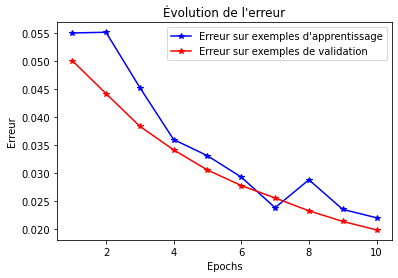

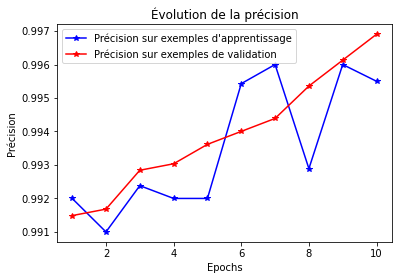

In [32]:
# Tests pour la première architecture
print("Tests de la première architecture\n")

print("Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02\n")
test(model1, epochs=15, batch_size=300, steps_per_epoch=10, validation_split=0.02)

print("Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 10, validation_split: 0.01\n")
test(model1, epochs=10, batch_size=200, steps_per_epoch=10, validation_split=0.01)

Tests de la deuxième architecture

Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02

Epoch 1/15
15/15 - 2s - loss: 0.7104 - accuracy: 0.5160 - val_loss: 0.5076 - val_accuracy: 0.9528 - 2s/epoch - 166ms/step
Epoch 2/15
15/15 - 0s - loss: 0.4028 - accuracy: 0.9539 - val_loss: 0.3010 - val_accuracy: 0.9557 - 352ms/epoch - 23ms/step
Epoch 3/15
15/15 - 0s - loss: 0.2427 - accuracy: 0.9588 - val_loss: 0.1756 - val_accuracy: 0.9729 - 347ms/epoch - 23ms/step
Epoch 4/15
15/15 - 0s - loss: 0.1465 - accuracy: 0.9759 - val_loss: 0.1093 - val_accuracy: 0.9826 - 349ms/epoch - 23ms/step
Epoch 5/15
15/15 - 0s - loss: 0.0942 - accuracy: 0.9848 - val_loss: 0.0747 - val_accuracy: 0.9880 - 346ms/epoch - 23ms/step
Epoch 6/15
15/15 - 0s - loss: 0.0659 - accuracy: 0.9899 - val_loss: 0.0544 - val_accuracy: 0.9915 - 334ms/epoch - 22ms/step
Epoch 7/15
15/15 - 0s - loss: 0.0485 - accuracy: 0.9913 - val_loss: 0.0415 - val_accuracy: 0.9923 - 355ms/epoch - 24ms/step
Epoch 8/15
15

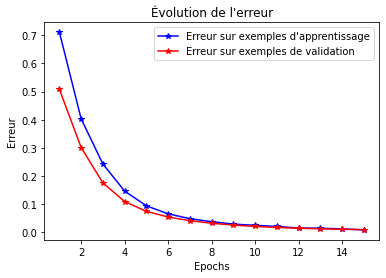

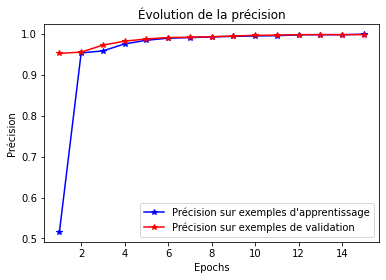

Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01

Epoch 1/10
8/8 - 2s - loss: 0.0129 - accuracy: 0.9975 - val_loss: 0.0082 - val_accuracy: 0.9986 - 2s/epoch - 222ms/step
Epoch 2/10
8/8 - 0s - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0073 - val_accuracy: 0.9986 - 243ms/epoch - 30ms/step
Epoch 3/10
8/8 - 0s - loss: 0.0070 - accuracy: 0.9987 - val_loss: 0.0065 - val_accuracy: 0.9988 - 276ms/epoch - 35ms/step
Epoch 4/10
8/8 - 0s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 0.0057 - val_accuracy: 0.9990 - 267ms/epoch - 33ms/step
Epoch 5/10
8/8 - 0s - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9992 - 260ms/epoch - 32ms/step
Epoch 6/10
8/8 - 0s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.0046 - val_accuracy: 0.9990 - 261ms/epoch - 33ms/step
Epoch 7/10
8/8 - 0s - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9992 - 266ms/epoch - 33ms/step
Epoch 8/10
8/8 - 0s - loss: 0.0082 - accuracy: 0.9981 - val_los

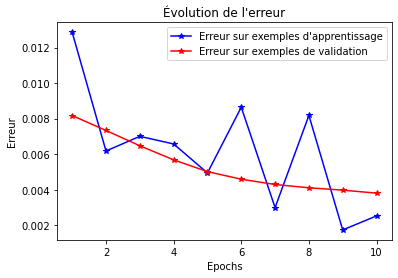

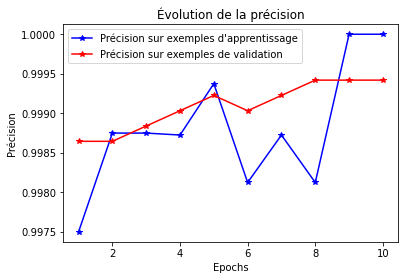

In [33]:
# Tests pour la deuxième architecture
print("Tests de la deuxième architecture\n")

print("Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02\n")
test(model2, epochs=15, batch_size=300, steps_per_epoch=15, validation_split=0.02)

print("Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01\n")
test(model2, epochs=10, batch_size=200, steps_per_epoch=8, validation_split=0.01)

Tests de la troisième architecture

Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02

Epoch 1/15
15/15 - 3s - loss: 0.3974 - accuracy: 0.8616 - val_loss: 0.1774 - val_accuracy: 0.9534 - 3s/epoch - 218ms/step
Epoch 2/15
15/15 - 1s - loss: 0.1202 - accuracy: 0.9710 - val_loss: 0.0726 - val_accuracy: 0.9832 - 507ms/epoch - 34ms/step
Epoch 3/15
15/15 - 1s - loss: 0.0573 - accuracy: 0.9848 - val_loss: 0.0395 - val_accuracy: 0.9905 - 859ms/epoch - 57ms/step
Epoch 4/15
15/15 - 1s - loss: 0.0364 - accuracy: 0.9909 - val_loss: 0.0229 - val_accuracy: 0.9942 - 650ms/epoch - 43ms/step
Epoch 5/15
15/15 - 1s - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.0147 - val_accuracy: 0.9973 - 509ms/epoch - 34ms/step
Epoch 6/15
15/15 - 0s - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0108 - val_accuracy: 0.9977 - 494ms/epoch - 33ms/step
Epoch 7/15
15/15 - 0s - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0085 - val_accuracy: 0.9985 - 480ms/epoch - 32ms/step
Epoch 8/15
1

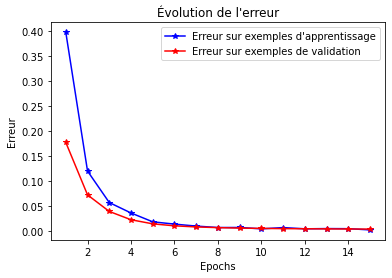

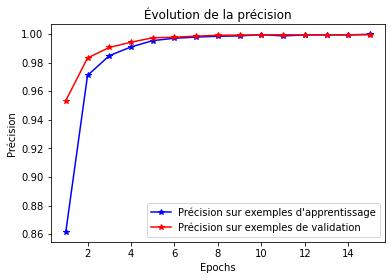

Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01

Epoch 1/10
8/8 - 2s - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9990 - 2s/epoch - 311ms/step
Epoch 2/10
8/8 - 0s - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0059 - val_accuracy: 0.9985 - 355ms/epoch - 44ms/step
Epoch 3/10
8/8 - 0s - loss: 0.0102 - accuracy: 0.9962 - val_loss: 0.0051 - val_accuracy: 0.9988 - 357ms/epoch - 45ms/step
Epoch 4/10
8/8 - 1s - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 0.9990 - 540ms/epoch - 67ms/step
Epoch 5/10
8/8 - 0s - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9994 - 426ms/epoch - 53ms/step
Epoch 6/10
8/8 - 0s - loss: 0.0076 - accuracy: 0.9987 - val_loss: 0.0039 - val_accuracy: 0.9994 - 395ms/epoch - 49ms/step
Epoch 7/10
8/8 - 1s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9994 - 501ms/epoch - 63ms/step
Epoch 8/10
8/8 - 0s - loss: 0.0038 - accuracy: 0.9994 - val_los

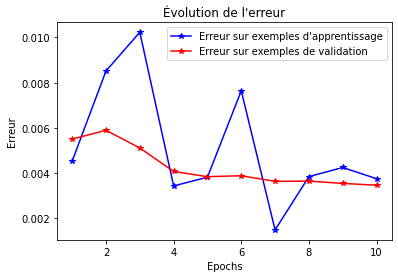

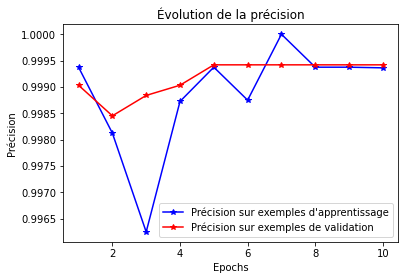

In [34]:
# Tests pour la troisième architecture
print("Tests de la troisième architecture\n")

print("Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02\n")
test(model3, epochs=15, batch_size=300, steps_per_epoch=15, validation_split=0.02)

print("Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01\n")
test(model3, epochs=10, batch_size=200, steps_per_epoch=8, validation_split=0.01)

Tests de la quatrième architecture

Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02

Epoch 1/15
15/15 - 4s - loss: 0.3633 - accuracy: 0.8832 - val_loss: 0.1639 - val_accuracy: 0.9518 - 4s/epoch - 242ms/step
Epoch 2/15
15/15 - 1s - loss: 0.1010 - accuracy: 0.9781 - val_loss: 0.0511 - val_accuracy: 0.9884 - 590ms/epoch - 39ms/step
Epoch 3/15
15/15 - 1s - loss: 0.0366 - accuracy: 0.9903 - val_loss: 0.0188 - val_accuracy: 0.9961 - 800ms/epoch - 53ms/step
Epoch 4/15
15/15 - 1s - loss: 0.0132 - accuracy: 0.9973 - val_loss: 0.0090 - val_accuracy: 0.9985 - 698ms/epoch - 47ms/step
Epoch 5/15
15/15 - 1s - loss: 0.0070 - accuracy: 0.9989 - val_loss: 0.0059 - val_accuracy: 0.9988 - 648ms/epoch - 43ms/step
Epoch 6/15
15/15 - 1s - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 0.9994 - 637ms/epoch - 42ms/step
Epoch 7/15
15/15 - 1s - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.0040 - val_accuracy: 0.9994 - 603ms/epoch - 40ms/step
Epoch 8/15
1

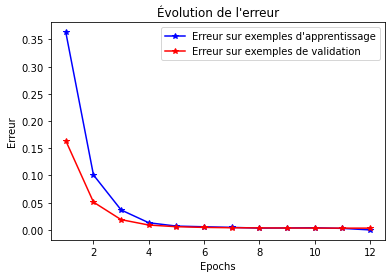

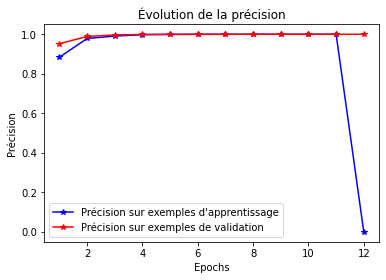

Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01

Epoch 1/10
8/8 - 3s - loss: 6.4413e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9994 - 3s/epoch - 358ms/step
Epoch 2/10
8/8 - 0s - loss: 0.0074 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 0.9994 - 426ms/epoch - 53ms/step
Epoch 3/10
8/8 - 1s - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9994 - 544ms/epoch - 68ms/step
Epoch 4/10
8/8 - 0s - loss: 3.2964e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9994 - 366ms/epoch - 46ms/step
Epoch 5/10
8/8 - 0s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9994 - 361ms/epoch - 45ms/step
Epoch 6/10
8/8 - 0s - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0029 - val_accuracy: 0.9994 - 434ms/epoch - 54ms/step
Epoch 7/10
8/8 - 0s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9994 - 448ms/epoch - 56ms/step
Epoch 8/10
8/8 - 1s - loss: 0.0029 - accuracy: 0.9994 -

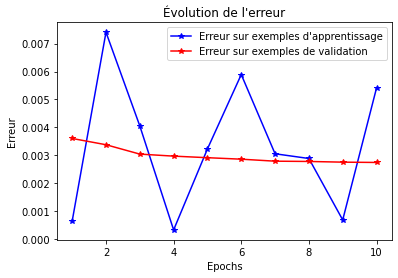

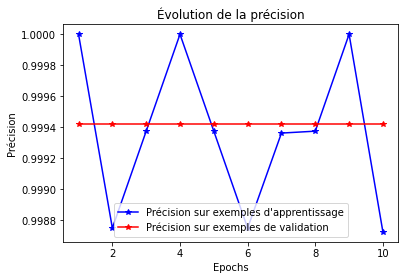

In [35]:
# Tests pour la quatrième architecture
print("Tests de la quatrième architecture\n")

print("Test 1 avec epochs: 15, batch_size: 300, steps_per_epoch: 15, validation_split: 0.02\n")
test(model4, epochs=15, batch_size=500, steps_per_epoch=15, validation_split=0.02)

print("Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01\n")
test(model4, epochs=10, batch_size=200, steps_per_epoch=8, validation_split=0.01)

Tests de la cinquième architecture

Test 1 avec epochs: 15, batch_size: 500, steps_per_epoch: 5, validation_split: 0.02

Epoch 1/15
5/5 - 3s - loss: 0.5401 - accuracy: 0.8380 - val_loss: 0.3953 - val_accuracy: 0.9439 - 3s/epoch - 698ms/step
Epoch 2/15
5/5 - 0s - loss: 0.3341 - accuracy: 0.9484 - val_loss: 0.2206 - val_accuracy: 0.9702 - 365ms/epoch - 73ms/step
Epoch 3/15
5/5 - 0s - loss: 0.1680 - accuracy: 0.9760 - val_loss: 0.1264 - val_accuracy: 0.9795 - 323ms/epoch - 65ms/step
Epoch 4/15
5/5 - 0s - loss: 0.1189 - accuracy: 0.9768 - val_loss: 0.0833 - val_accuracy: 0.9839 - 374ms/epoch - 75ms/step
Epoch 5/15
5/5 - 0s - loss: 0.0716 - accuracy: 0.9885 - val_loss: 0.0603 - val_accuracy: 0.9870 - 342ms/epoch - 68ms/step
Epoch 6/15
5/5 - 0s - loss: 0.0587 - accuracy: 0.9860 - val_loss: 0.0461 - val_accuracy: 0.9901 - 334ms/epoch - 67ms/step
Epoch 7/15
5/5 - 0s - loss: 0.0480 - accuracy: 0.9899 - val_loss: 0.0360 - val_accuracy: 0.9921 - 322ms/epoch - 64ms/step
Epoch 8/15
5/5 - 0s - loss:

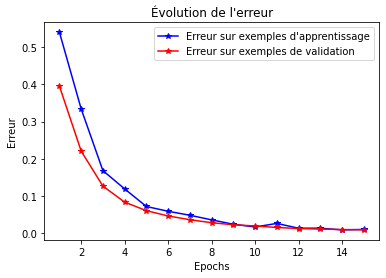

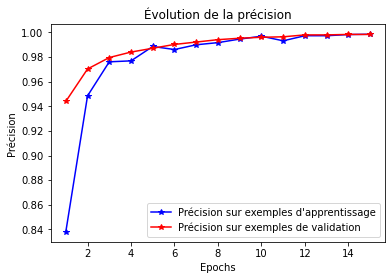

Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01

Epoch 1/10
8/8 - 3s - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0080 - val_accuracy: 0.9983 - 3s/epoch - 337ms/step
Epoch 2/10
8/8 - 1s - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0088 - val_accuracy: 0.9977 - 506ms/epoch - 63ms/step
Epoch 3/10
8/8 - 0s - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0077 - val_accuracy: 0.9979 - 443ms/epoch - 55ms/step
Epoch 4/10
8/8 - 0s - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0069 - val_accuracy: 0.9983 - 390ms/epoch - 49ms/step
Epoch 5/10
8/8 - 0s - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.0059 - val_accuracy: 0.9986 - 485ms/epoch - 61ms/step
Epoch 6/10
8/8 - 0s - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0059 - val_accuracy: 0.9988 - 498ms/epoch - 62ms/step
Epoch 7/10
8/8 - 0s - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0055 - val_accuracy: 0.9988 - 477ms/epoch - 60ms/step
Epoch 8/10
8/8 - 0s - loss: 0.0048 - accuracy: 0.9981 - val_los

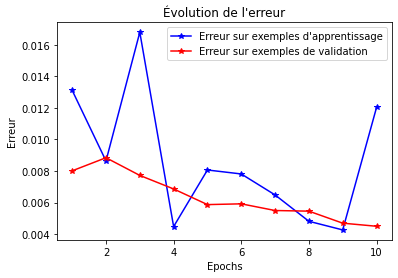

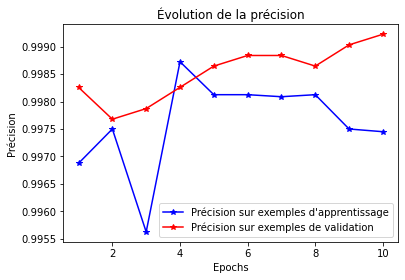

In [36]:
# Tests pour la cinquième architecture
print("Tests de la cinquième architecture\n")

print("Test 1 avec epochs: 15, batch_size: 500, steps_per_epoch: 5, validation_split: 0.02\n")
test(model5, epochs=15, batch_size=500, steps_per_epoch=5, validation_split=0.02)

print("Test 2 avec epochs: 10, batch_size: 200, steps_per_epoch: 8, validation_split: 0.01\n")
test(model5, epochs=10, batch_size=200, steps_per_epoch=8, validation_split=0.01)


----
#### Tests
Prenons des sms au hasard et demandons quelle confiance on peut avoir en eux : 

In [38]:
des_sms = ['Did you catch the bus ? If yes, we can lunch together ! see you !!']
des_sms.append('Congrats! 1 year of magnificient diner at the RU1 MontHouy !!! call now!')
## transformation des textes en vecteurs 
des_sms_tokenises = tokenizer.texts_to_matrix(des_sms, mode='freq')
## demande de prédiction
predictions1 = model1.predict(des_sms_tokenises)
predictions2 = model2.predict(des_sms_tokenises)
predictions3 = model3.predict(des_sms_tokenises)
predictions4 = model4.predict(des_sms_tokenises)
predictions5 = model5.predict(des_sms_tokenises)

1/1 [==============================] - 0s 41ms/step


In [39]:
print("\tAvec Architecture 1")
for i in range(0, len(des_sms)):
    print(f'\"{des_sms[i]}\" -- confiance = {predictions1[i][0]*100:.2f}%')
    
print("\n\tAvec Architecture 2")  
for i in range(0, len(des_sms)):
    print(f'\"{des_sms[i]}\" -- confiance = {predictions2[i][0]*100:.2f}%')

print("\n\tAvec Architecture 3")
for i in range(0, len(des_sms)):
    print(f'\"{des_sms[i]}\" -- confiance = {predictions3[i][0]*100:.2f}%')
    
print("\n\tAvec Architecture 4")
for i in range(0, len(des_sms)):
    print(f'\"{des_sms[i]}\" -- confiance = {predictions4[i][0]*100:.2f}%')
    
print("\n\tAvec Architecture 5")
for i in range(0, len(des_sms)):
    print(f'\"{des_sms[i]}\" -- confiance = {predictions5[i][0]*100:.2f}%')

	Avec Architecture 1
"Did you catch the bus ? If yes, we can lunch together ! see you !!" -- confiance = 86.54%
"Congrats! 1 year of magnificient diner at the RU1 MontHouy !!! call now!" -- confiance = 81.44%

	Avec Architecture 2
"Did you catch the bus ? If yes, we can lunch together ! see you !!" -- confiance = 98.63%
"Congrats! 1 year of magnificient diner at the RU1 MontHouy !!! call now!" -- confiance = 97.45%

	Avec Architecture 3
"Did you catch the bus ? If yes, we can lunch together ! see you !!" -- confiance = 99.67%
"Congrats! 1 year of magnificient diner at the RU1 MontHouy !!! call now!" -- confiance = 99.16%

	Avec Architecture 4
"Did you catch the bus ? If yes, we can lunch together ! see you !!" -- confiance = 99.05%
"Congrats! 1 year of magnificient diner at the RU1 MontHouy !!! call now!" -- confiance = 97.85%

	Avec Architecture 5
"Did you catch the bus ? If yes, we can lunch together ! see you !!" -- confiance = 99.68%
"Congrats! 1 year of magnificient diner at the R

---
### TensorBoard

Maintenant, en bonus, <span style="background-color:yellow">utilisez un "TensorBoard"</span> pour représenter les courbes d'apprentissage..
(cf. exemple [Detection d'Alertes avec TensorBoard](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionDetectionAlertesTensorBoard.ipynb) )

(dupliquez votre fichier notebook pour en créer un nouveau)


---
## <span style="color:red;background-color:yellow">TRAVAIL A RENDRE</span>

* Vous expliquerez le fonctionnement des paramètres epochs, steps_per_epoch, batch_size, et leur impact sur la qualité de l'apprentissage
* Vous devrez tester 5 différentes architectures de réseau (nb de couches), ainsi que différentes configurations (fonctions d'activation, méthodes d'optimisation, méthode de calcul de l'erreur, bach_size, ......), ainsi qu'au moins deux méthodes de création de sacs de mots (texts_to_matrix) en expliquant leurs fonctionnement
* Tentez d'expliquer les différences de résultat
* Vous enverrez un fichier pdf avec pour chaque configuration :
    * l'architecture du réseau (un copier coller du bloc 'TODO: définir la structure du réseau')
    * le déroulé de l'apprentissage (un copier coller du graphique sur la précision)